C:\Users\hoang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\hoang\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


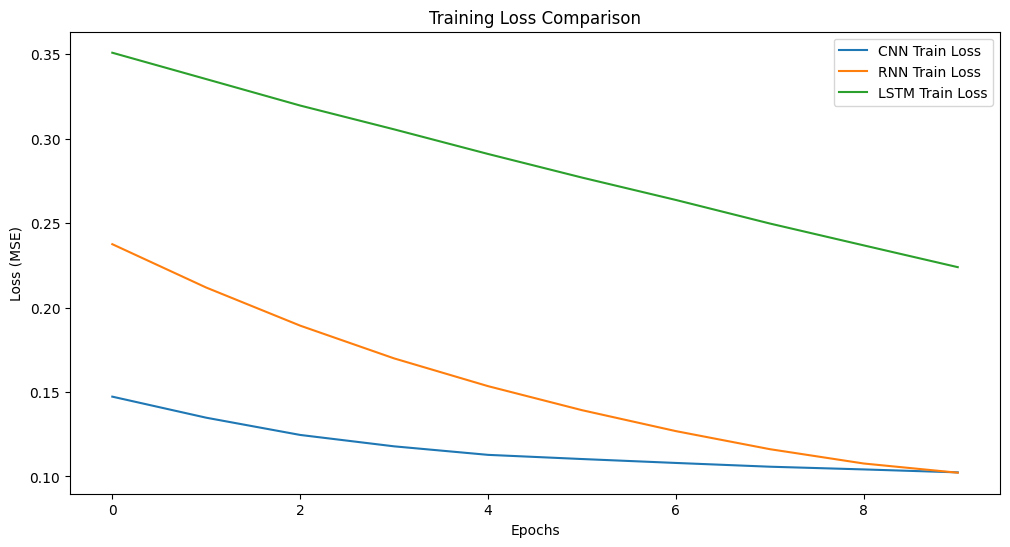

In [1]:
import tkinter as tk
from tkinter import messagebox
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, SimpleRNN, Flatten
from sklearn.preprocessing import MinMaxScaler

# 1. Đọc dữ liệu từ file CSV
def load_data():
    df = pd.read_csv("real_estate_data.csv")
    df["location"] = df["location"].apply(lambda x: 1 if x == "Hanoi" else 0)  # Biến đổi vị trí thành số
    return df

# 2. Chuẩn hóa và tiền xử lý dữ liệu
df = load_data()
X = df[["location", "size"]].values
y = df["price"].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# 3. Khởi tạo và huấn luyện các mô hình CNN, RNN, LSTM
def build_models():
    models = {
        "CNN": Sequential([
            Conv1D(32, 2, activation="relu", input_shape=(2, 1)),
            Flatten(),
            Dense(1)
        ]),
        "RNN": Sequential([
            SimpleRNN(32, activation="relu", input_shape=(2, 1)),
            Dense(1)
        ]),
        "LSTM": Sequential([
            LSTM(32, activation="relu", input_shape=(2, 1)),
            Dense(1)
        ])
    }
    history = {}
    for name, model in models.items():
        model.compile(optimizer="adam", loss="mse")
        hist = model.fit(X_scaled, y_scaled, epochs=10, verbose=0)
        history[name] = hist.history["loss"]
    return models, history

models, history = build_models()

# 4. Hàm dự đoán giá bất động sản
def predict_price(location, size):
    input_data = scaler_X.transform([[location, size]])
    input_data = input_data.reshape(1, 2, 1)

    predictions = {}
    for name, model in models.items():
        pred = model.predict(input_data)
        predictions[name] = scaler_y.inverse_transform(pred)[0, 0]
    return predictions

# 5. Hàm tạo biểu đồ so sánh loss
def plot_comparison(history):
    plt.figure(figsize=(12, 6))
    for model_name, loss in history.items():
        plt.plot(loss, label=f"{model_name} Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.title("Training Loss Comparison")
    plt.legend()
    plt.show()

# 6. Giao diện người dùng với Tkinter
root = tk.Tk()
root.title("Dự đoán giá bất động sản")

tk.Label(root, text="Vị trí:").grid(row=0, column=0, padx=10, pady=5)
location_var = tk.StringVar(value="Hanoi")
location_menu = tk.OptionMenu(root, location_var, "Hanoi", "Ha Dong")
location_menu.grid(row=0, column=1, padx=10, pady=5)

tk.Label(root, text="Diện tích (m2):").grid(row=1, column=0, padx=10, pady=5)
size_entry = tk.Entry(root)
size_entry.grid(row=1, column=1, padx=10, pady=5)

# Hàm xử lý khi nhấn nút Dự đoán
def on_predict():
    location = 1 if location_var.get() == "Hanoi" else 0
    try:
        size = float(size_entry.get())
    except ValueError:
        messagebox.showerror("Lỗi", "Vui lòng nhập số hợp lệ cho diện tích")
        return

    predictions = predict_price(location, size)
    result_text = "\n".join([f"{name} dự đoán: {price:,.2f} ngàn VNĐ" for name, price in predictions.items()])
    messagebox.showinfo("Kết quả dự đoán", result_text)
    plot_comparison(history)  # Hiển thị biểu đồ sau khi dự đoán

# Nút dự đoán
predict_button = tk.Button(root, text="Dự đoán giá", command=on_predict)
predict_button.grid(row=2, column=0, columnspan=2, pady=10)

# Chạy ứng dụng
root.mainloop()
